# GMDL - Final Project
### Liran Nochumsohn - 204693410

### Introduction

Our final project focuses on the problem of Open Set Recognition
(OSR). Unlike traditional classification problems, where a model is trained
and tested on the same set of classes, OSR refers to a scenario where, in
addition to the known classes the classifier was trained on, additional new
classes might be present during test-time. In fact, this is closely related
to the problem of out-of-distribution (OOD) detection.

More concretely, in this project, we are tasked with an image classification problem on the MNIST dataset. However, our model should be
able to not only correctly classify MNIST examples but also flag unseen
classes during test-time as ’Unknown’. This means, for example, that
during test we will get not only examples from MNIST’s test dataset but
also examples from possibly unrelated datasets (e.g., we may get letters
from some alphabet or even images of animals, etc.).

Our method uses a multi-task CNN based AE + data augmentation for classification. We fit GMM to the latent representations of the train dataset to learn a underlying distribtuion. Using the estimated distribution, we then nullify any OOD examples from the test set.\
With our method we achieve over 95% accuracy on the 500 OOD binary classification test examples, over 99% on the entire test set OOD binary classification and over 95% on the classification of all labels + unknowns on the entire test set.


In [ ]:
# Import Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

/home/lirannoc/.conda/envs/da/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0
NVIDIA GeForce RTX 3090


# 1) Data and Preprocessing

### Seed

In [ ]:
torch.manual_seed(0)
np.random.seed(0)


###  Transformations

Here are different transform compositions, each applied within different stages in the pipeline.\
 All images are eventually fed to the model with size 28,  greyscale and after normalization.

The reason the normalization is separated in the train-transformation is due to the data augmentation transformation -augment- which requires the values of the pixels to stay in integers.\
 Therefore, first the augmentation takes places and then comes the normalization.


In [ ]:
# MNIST
# resize and greyscale
transform_train = transforms.Compose([
                transforms.ToTensor(),            
                transforms.Resize(28)])

# normalizer
pixel_mean = 33.3100
pixel_std = 78.567
normalize = transforms.Normalize(mean=pixel_mean/255, std=pixel_std/255)

# resize and greyscale for test (direct)
transform_test = transforms.Compose([
                transforms.ToTensor(),            
                transforms.Resize(28),
                normalize])

# CIFAR10 - OOD
transform_cifar = transforms.Compose([
                transforms.ToTensor(),           
                transforms.Resize(28),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                transforms.Grayscale()])

### Datasets and Dataloaders 


#### MNIST
In this project we train our model based on a subset of size 10,000 examples sampled uniformly from the greater MNIST dataset. \
Of the total 10,000 examples, 2000 examples are used for validation and the rest for training.
We use the full size MNIST test set, i.e. 10,000 examples. 

In [ ]:
total_train_size = 60000
val_size = 2000
train_size = 10000
batch_size = 16
test_size = 10000


# if the data exists localy import it
try:
    print("import MNIST from local directory")
    mnist_train = torchvision.datasets.MNIST('path/to/MNIST_root/'
                                            , transform = transform_train
                                            , train=True)
    mnist_test = torchvision.datasets.MNIST('path/to/MNIST_root/'
                                            , transform = transform_test
                                            , train=False)

# else download the data  
except:
    print("download MNIST to local directory")
    mnist_train = torchvision.datasets.MNIST('path/to/MNIST_root/'
                                             , transform = transform_train
                                             , train=True
                                             , download = True)
    mnist_test = torchvision.datasets.MNIST('path/to/MNIST_root/'
                                            , transform = transform_test
                                            , train=False
                                            , download = True)

# take a subset of 10,000 for train and 2,000 for validation    
mnist_train = torch.utils.data.Subset(mnist_train,np.arange(train_size +  val_size))
train_set, val_set = torch.utils.data.random_split(mnist_train, [train_size, val_size ])

# mix the testset (even though it is unnecessary)
test_set  = torch.utils.data.Subset(mnist_test,np.arange(test_size))


# create the lodaers for the 
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                      shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                      shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=test_size,
                                         shuffle=False, num_workers=2)



import MNIST from local directory



### CIFAR10 - (OSR)

We use 500 CIFAR10 examples for the OOD data.

In [ ]:
# todo change to cifar

# import/download MNIST for the OOD test.
ood_size = 500
try:
    print("import CIFAR10 from local directory")
    cifar_data = torchvision.datasets.CIFAR10('path/to/CIFAR10_root/',transform = transform_cifar)
    
except:
    print("download CIFAR10 to local directory")
    cifar_data = torchvision.datasets.CIFAR10('path/to/CIFAR10_root/',transform = transform_cifar, download = True)

    
cifarloader = torch.utils.data.DataLoader(cifar_data, batch_size=ood_size ,
                                      shuffle=True, num_workers=2)

import CIFAR10 from local directory


The OSR torch-Dataset class takes the CIFAR10 OOD dataset and the MNIST test set, combines them together to form the OSR test set used in the project. If you wish to add your own Dataset class you can overide this class, else you can simply send suitable arguments as described below corresponding to in-distribution or out-of-distribution.

In [ ]:
# torch dataset class for the OSR data
class OSRDataset(Dataset):
    """
    Args-
        X_data_id: in distrubtion data (MNIST),
                takes input shape (n,1,28,28) tensor
        y_data_id: in distrubtion labels (MNIST),
                takes input shape (n) tensor.
        X_data_ood: out of distribution data (CIFAR 10),
                takes input shape (n,1,28,28) tensor.

  
        tranform: the transformation to be applied.
    """
    def __init__(self,X_data_id, y_data_id, X_data_ood, transform = None):
        
        self.data = torch.concat([cifar_X,test_X])
        # set 10 to be the unknown example and 0-9 to be the known MNIST examples
        self.targets = torch.concat([(10)*torch.ones((len(cifar_X))),test_y])
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = self.data[idx]
        labels = self.targets[idx]        
        return images, labels

# get the CIFAR10 subset test tensor     
dataiter = iter(cifarloader)
cifar_X, cifar_y  = dataiter.next()

# get the MNIST test tensor
dataiter = iter(testloader)
test_X, test_y  = dataiter.next()
    
    
OSR_set = OSRDataset(test_X, test_y, cifar_X)    
OSRloader =  torch.utils.data.DataLoader(OSR_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


#### Plot a sample from the OSR set:
note: if can't see OOD examples, run the cell again, there's a chance of $ \frac{500}{10,000}$ for one to appear.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


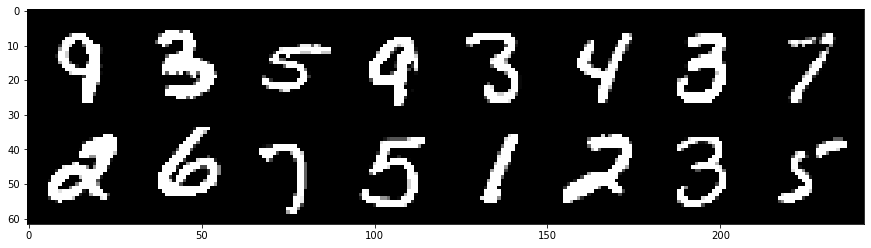

In [ ]:

# used for plotting images
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize = (15,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random images from the OSR set
dataiter = iter(OSRloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


## Augmentations - RandAugment

In this project we use augmention to improve generalization. Instead of picking an augmentation strategy without proper justification, we use a method called RandAugment [[1]](#[1]).

Briefly, RandAugment is an augmentation search algorithm which attempts to find an optimal augmentation policy for a given dataset and model.\
 The optimal augmentation policy is chosen based on the highest validation error.
Each policy is comprised of links of 14 possible transformations, namely:

* ShearX/Y: Shear the image along the horizontal (vertical) axis with rate magnitude.
* TranslateX/Y: Translate the image in the horizontal (vertical) direction by magnitude number of pixels.
* Rotate: Rotate the image magnitude degrees.
* AutoContrast: Maximize the the image contrast, by making the darkest pixel black and lightest pixel white
* Invert: Invert the pixels of the image.
* Equalize: Equalize the image histogram
* Solarize: Invert all pixels above a threshold value of magnitude.
* Posterize: Reduce the number of bits for each pixel to magnitude bits.
* Contrast: Control the contrast of the image. A magnitude=0 gives a gray image, whereas magnitude=1 gives the original image.
* Color: Adjust the color balance of the image, in a manner similar to the controls on a colour TV set. A magnitude=0 gives a black & white image, whereas magnitude=1 gives the original image
* Brightness:  Adjust the brightness of the image. A magnitude=0 gives a black image, whereas magnitude=1 gives the original image.
* Sharpness: Adjust the sharpness of the image. A magnitude=0 gives a blurred image, whereas magnitude=1 gives the original image.
* Cutout: Set a random square patch of side-length magnitude pixels to gray.
* Sample Pairing: Linearly add the image with another image (selected at random from the same mini-batch) with weight magnitude, without changing the label.

Each of the mentioned transformations are applied with an equal probability $\frac{1}{14}$. The search space is of size $10^2$, such that each possibility corresponds to a magnitude $mag \in \{0,1,2,3,4,5,6,7,8,9\}$ of 2 linked transformations. Each magnitude integer is mapped to a value within the range of inputs of each transformation, for example 0-9 is mapped to a range of degrees [-30,30] for the rotation transformation.\

Example of some policies:


    (mag1 = 3, mag2 = 0)

    (mag1 = 4, mag2 = 3)

    (mag1 = 9, mag2 = 1)
    


Note that there is no chance the numbers will flip (making 6 become 9 and vice versa) since the max rotation is 30 degrees clockwise and anticlockwise.


##### Randaugment Experiments
We test the different $10^2$ policies (possibilities) using grid search on the same baseline model presented here for 30 epochs.\
 Each policy is applied for 3 runs and the validation mean is returned and used for the final decision.


##### Results - best policy
After searching for the best augmentations policy we found that (mag1 = 2, mag2 = 1) perfoms best. We'll use a built-in pytorch implementation for randaugment.\
 The results table can be found in the attached pdf.

In the next cell we can see a sample of how the augmentations take place.

Original


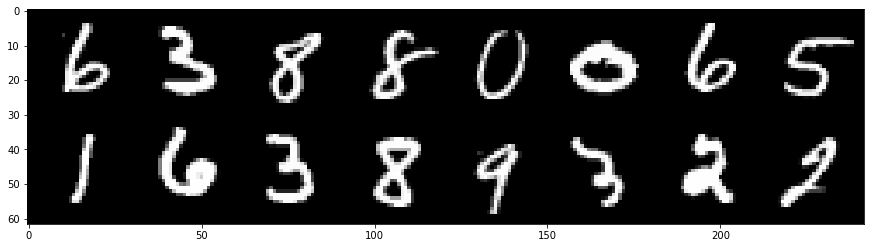

Augmented


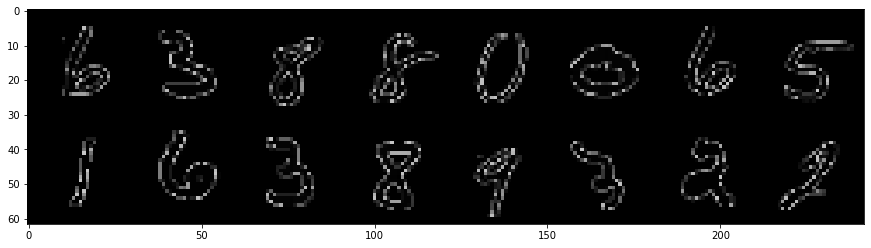

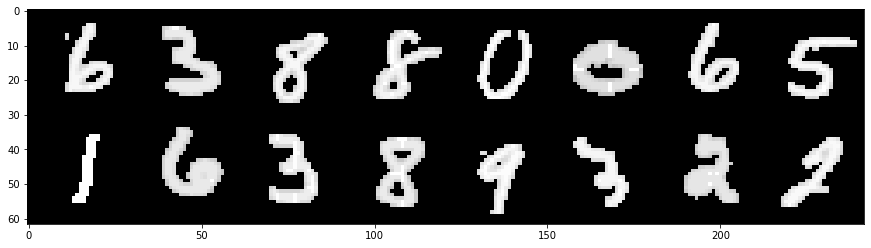

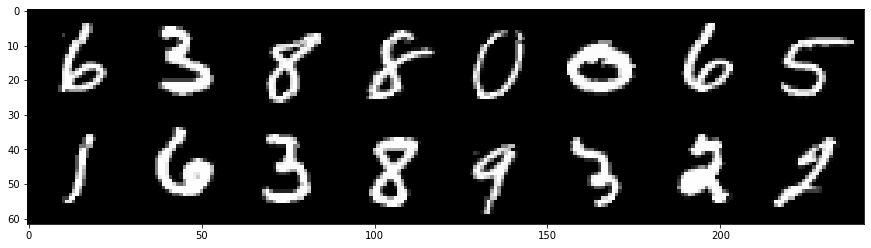

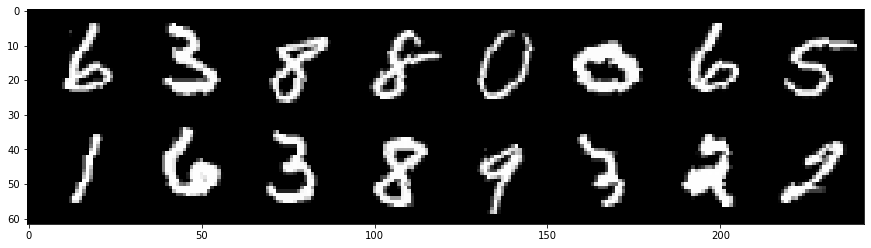

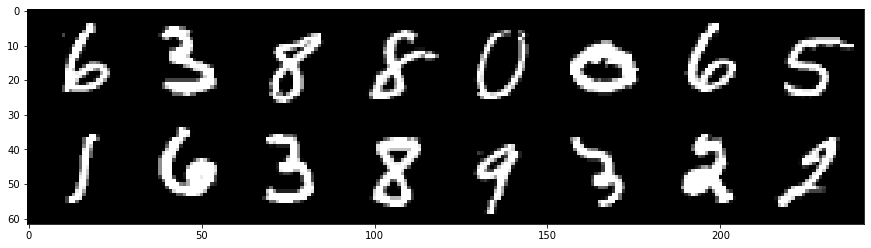

In [ ]:
# MNIST - Augmentation
mag1 = 2
mag2 = 1
augment = transforms.Compose([
                transforms.ConvertImageDtype(torch.uint8),
                transforms.RandAugment(num_ops = 1, magnitude = mag1, num_magnitude_bins = 10),  
                transforms.RandAugment(num_ops = 1, magnitude = mag2, num_magnitude_bins = 10), 
                transforms.ConvertImageDtype(torch.float32)])

dataiter = iter(trainloader)
images,_  = dataiter.next()

print("Original")
imshow(torchvision.utils.make_grid(images))

print("Augmented")
for i in range(5):
    im1 = augment(images)
    imshow(torchvision.utils.make_grid(im1))

# 2) Models

In section we present the models used for the problem and we train the 2 models: baseline and OSR-model.

### Strategy
The approach we chose is to train a multi-task CNN autoencoder as presented in [[2]](#[2]). And then cluster the vectors in the latent space using GMM.\
From the examples in the latent space (trasin only) we find a log-likelihood threshold that will determine which example are in distribution and which not.
The process of picking a threshold is presented in following cells. Strategy layout:
* Train the baseline model, a multi-task autoencoder.
* Run GMM on the trainset in the latent space of the autoencoders embedded layer.
* Find a log-likelihood threshold from the trainset and support it based on the validation set, (described later).
* Use the threshold to nullify OOD examples in the test set, and label them as 10.
* get the accuracy of the total testset and precision of the OOD examples only.

The total overhead is approximately $0.04$. If training the baseline takes $x$ time, then with GMM and other computations adds it up to $1.04x$.



The baseline model:\
We construct a 2-convolution encoder and decoder such that the latent representation is used for classification and the decoded data form a reconstruction of the image.\
The implemntation below is slightly different from the original paper because some hyperparams were changed and we added avg pooling and changed/added layers in the form of linear layers.

## Baseline AE - Implementation

### Hyperparameters
In the process of finding for an AE we attempted a few model variations lastly coming up with the one implemented here. Some of the hyperparms tests:
* model: FC AE , CNN AE.
* encoder/ decoder: 1 convolution layer, 2 convolution layers.
* embedded layer size: 10, 20, 50 , 100.
* max pooling, average pooling, no pooling.

The best performing model: CNN AE, 2 conv layers for encoder/decoder, hidden size =100. We could also test more extended models but as pointed in the instruction, 
the models must not to great.

Alot of focus went also on the hyperparameters for the augmentation, as described above.




In [ ]:
class Baseline(nn.Module):
    def __init__(self, hidden_size = 100, num_class = 10):
        """Baseline AE

        Args:
            hidden_size (int, optional): The hidden size of the embedded layer. Defaults to 50.
            num_class (int, optional): The number of classes to classify. Defaults to 10.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_class = num_class

        # encoder
        self.encoder1 = nn.Conv2d(1, 6 , kernel_size=2, stride=2, padding=1) 
        self.pool = torch.nn.AvgPool2d(2)
        self.encoder2 = nn.Conv2d(6, 12 , kernel_size=2, stride=1, padding=1)  
        self.linear1 =nn.Linear(12*8*8,hidden_size)

        #decoder
        self.linear2 =nn.Linear(hidden_size,12*8*8)
        self.decoder1 = nn.ConvTranspose2d(12, 4, kernel_size=3, stride=2, padding=1) 
        self.decoder2 = nn.ConvTranspose2d(4, 1, kernel_size=2, stride=2, padding=1) 

        self.classifier = nn.Linear(hidden_size,10)

    def forward(self, x):
        # encode
        h = self.encode(x)

        logits = self.classifier(h)
        logits = logits.flatten(start_dim=1)

        #decode
        reconstruction = self.decode(h)
        return logits, reconstruction

    def encode(self,x):
        h = self.encoder1(x)
        h = self.pool(h)
        h = F.relu(h)
        h = self.encoder2(h)
        h = F.relu(h)
        h = h.flatten(1) 
        h = self.linear1(h)
        return h

    def decode(self,h):
        h = self.linear2(h)
        h = h.reshape(h.shape[0],12,8,8)

        reconstruction = self.decoder1(h)
        reconstruction = F.relu(reconstruction)
        reconstruction = self.decoder2(reconstruction)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction


    
# quick-test
a = torch.rand(10,1,28,28)
n = Baseline()
out = n(a)
print(out[1].shape)


torch.Size([10, 1, 28, 28])


## OSR Model Extension

This class takes a baseline model, learns GMM and then used for predicting the 11th OOD class (marked as label 10).

In [ ]:
class OSR():
    def __init__(self, baseline_model):
        """This class takes a baseline model, learns GMM and then used for classifying the unkown OOD class (marked as label 10).

        Args:
            baseline_model (_type_): A baseline AE trained model for learning an additional OOD class.
        """
        self.baseline_model = baseline_model
        self.gmm = None
        self.threshold = None
        self.scores = None
        
        
    def fit(self, loader = trainloader):
        """This method applies GMM on a given dataset (loader). All log-likelihood scores are saved.

        Args:
            loader (_type_, optional): Dataset loader for applying GMM. Defaults to trainloader.
        """
        z,X,y,pred_y = self.get_embedding(loader) 
        self.gmm = GaussianMixture(n_components=10, random_state=0).fit(z)
        self.scores = self.gmm.score_samples(z)
                                       
    def forward(self,z = None,pred_y = None, loader = None, risk = None):
        """Retuns the labels of a dataset including the OOD unknown label.

        Args:
            z (_type_, optional): latent representation of the data. Defaults to None.
            pred_y (_type_, optional): baseline model's output .
            loader (_type_, optional): if z and pred_y are not defined, can use a dataloader as input.
            risk (_type_, optional): the fraction of data examples to be sarificed to determine a threshold.
                                     If not given, a default risk from the fit function is used.

        Returns:
            ood_pred_y: the classfied labels including the OOD unkown labels (as 10).
            ood_pred: binary classes, 1 for unkown as 0 for the rest.
        """
        
        if loader is None:
            if z is None or pred_y is None:
                raise Exception("missing input, loader or z and pred_y")            
        else:            
            z,X,y,pred_y = self.get_embedding(loader)
            
        if risk is None:
            if self.threshold is None:
                raise Exception("threshold is null, must run fit() to get threshold")
            threshold = self.threshold
        else:
            threshold = self.__create_threshold(risk,self.scores)
        
        score_z = self.gmm.score_samples(z)

        # OOD predictions (binary)
        ood_pred = np.array(score_z<threshold, dtype=int)

        # All label prediction with unknowns (11 labels)
        predicted_true_index = np.where(ood_pred  == 1)[0]
        ood_pred_y = pred_y.clone()
        ood_pred_y[predicted_true_index] = 10
        
        return ood_pred_y, ood_pred
        
        
    def __create_threshold(self ,risk,scores):
        sorted_scores = np.sort(scores)
        if risk >0 and risk <1:
            risk = int(len(scores)*risk)
        if risk <0:
            raise Exception("Sorry, no numbers below zero")
        risk = int(risk)
        threshold = sorted_scores[risk:risk+1][0]
        return threshold


    def get_embedding(self, loader,normalizer = True):
        """This function gets the embedded vectors in the latent space of a given baseline model

        Args:
            loader (_type_): torch Dataset loader.
            normalizer (bool, optional): whether to normalize the input. This is important because the 
                                        trainloader pre-normalizes the imputs, However, the validation and train loader
                                        do not perform normalization which is why it is important to normalize in the
                                        loop. Defaults to True.

        Returns:
            _type_: (latent representation, X, true y, predicted y)
        """
        self.baseline_model.eval()

        for i, data in enumerate(loader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # normalize
            if normalizer == True:
                inputs = normalize(inputs)            
            with torch.no_grad():
                embedding = self.baseline_model.encode(inputs)
                logits,_ = self.baseline_model(inputs)
            _, preds = torch.max(logits, 1)

            if i==0:
                X_embedding = embedding.cpu()
                X = inputs.cpu()
                y = labels.cpu()
                pred_y = preds.cpu()
            else:
                X_embedding = torch.concat([X_embedding,embedding.cpu()])
                X = torch.concat([X,inputs.cpu()])
                y = torch.concat([y,labels.cpu()])
                pred_y = torch.concat([pred_y,preds.cpu()])

        return X_embedding.cpu(),X,y,pred_y
        

### Trainer and Evaluator - implementations

In [ ]:


def trainer(net, optimizer, epochs, criterion, mag = False, aug_multi = 1):
    """
    This function trains a given model
    Args:
        mag: the magnitude of the augmentation, default is no augmentations.
        aug_multi: the number of augmentations to apply for a given batch, 
                e.g. aug_multi = 2 will create batch_size*2 augmentations.
    the other args are pretty obvious.

    returns the trained model, train and validation reconstruction loss,
    classification loss and accuracy.

"""

    train_loss_rec = []
    train_loss_logits = []
    val_loss_logits = []
    val_loss_rec = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        running_loss_logits = 0.0
        running_corrects = 0
        running_loss_rec = 0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            batch_size = inputs.shape[0]
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # apply augmentation
            if mag == True:
                for j in range(aug_multi):
                    augmented_inputs = augment(inputs)
                    inputs = torch.concat([inputs,augmented_inputs])
                    labels = torch.concat([labels,labels])
                                                                                
            inputs = normalize(inputs)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            logits, reconstruction = net(inputs)
            loss_logits = criterion[0](logits, labels)
            loss_reconstruction = criterion[1](reconstruction, inputs)
            total_loss = loss_logits + loss_reconstruction 

            total_loss.backward()
            optimizer.step()
            _, preds = torch.max(logits, 1)

            # print statistics
            running_corrects += torch.sum(preds == labels.data)
            running_loss_rec += loss_reconstruction.item()
            running_loss_logits += loss_logits.item()

         
        if mag == False:
            multi = 1
        else:
            multi = int(inputs.shape[0]/batch_size)
            
        epoch_loss_rec = running_loss_rec / (train_size*multi)
        epoch_loss_logits = running_loss_logits / (train_size*multi)
        epoch_acc = running_corrects.double() / (train_size*multi)
        
        train_loss_rec.append(epoch_loss_rec)
        train_loss_logits.append(epoch_loss_logits)
        train_acc.append(epoch_acc.cpu())

        print(f'{epoch} - Train rec loss: {epoch_loss_rec:.4f} Train logits loss: {epoch_loss_logits:.4f} Train acc: {epoch_acc:.4f}')
        
        # evaluate the model on the validation set
        evaluation_val = evaluate(net,valloader, criterion, normalizer = True )
        epoch_loss_rec, epoch_loss_logits, epoch_acc  = evaluation_val

        val_loss_rec.append(epoch_loss_rec)
        val_loss_logits.append(epoch_loss_logits)
        val_acc.append(epoch_acc.cpu())
        
        print(f'{epoch} - val rec loss: {epoch_loss_rec:.4f} val logits loss: {epoch_loss_logits:.4f} val acc: {epoch_acc:.4f}')


    print('Finished Training')
    output_dict = {'net':net,
                   'train loss logits': train_loss_logits,
                   'val loss logits': val_loss_logits,
                   'train loss rec': train_loss_rec,
                   'val loss rec': val_loss_rec,
                   'train acc': train_acc,
                   'val acc': val_acc
                  }
                        
    return  output_dict



def evaluate(net, loader, criterion, normalizer = True):
    """
    This function evaluates a given model
    Args:

    normalizer: whether to normalize the input. This is important because the 
    trainloader pre-normalizes the imputs, However, the validation and train loader
    do not perform normalization which is why it is important to normalize in the
    loop.

    the rest of the args are pretty obvious too

    returns reconstruction loss,
    classification loss and accuracy.

"""
    
    net.eval() 
    running_corrects = 0
    running_loss_rec = 0
    running_loss_logits = 0
    for i, data in enumerate(valloader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if normalizer:
            inputs = normalize(inputs)

        with torch.no_grad():
            logits, reconstruction = net(inputs)

        _, preds = torch.max(logits, 1)
        loss_logits = criterion[0](logits, labels)
        loss_reconstruction = criterion[1](reconstruction, inputs)

        # print statistics
        running_corrects += torch.sum(preds == labels.data)
        running_loss_rec += loss_reconstruction.item()
        running_loss_logits += loss_logits.item()

    epoch_loss_rec = running_loss_rec / (i*batch_size)
    epoch_loss_logits = running_loss_logits / (i*batch_size)
    epoch_acc = running_corrects.double() / (i*batch_size)

    output = (epoch_loss_rec, epoch_loss_logits,epoch_acc )
                        
    return  output

##### Special Note: 
Before we continue it is important to note that 2 different models are not necessary. That been said, the  OSR - model is the same as the baseline model.\
The only difference is that the OSR-model includes an additional clustering algorithm to rule out the classified labels of the OOD example with a single "unkown" label. This way, the the model's MNIST label classification of the estimated OOD will be ignored.

# 3) Training

### Train/Upload Baseline model


In [ ]:
# whether to load weights or retrain a new model.
load_weights = True

In [ ]:

path = './baseline_net.pth'
hidden_size = 100


# load weights
if load_weights== True:
    net = Baseline(hidden_size).to(device)
    net.load_state_dict(torch.load(path))
    baseline_net = net
    
# train model from scratch    
else:

    train_start = time.time()
    epochs = 100
    val_acc = []
    train_acc= []


    net = Baseline(hidden_size).to(device)
    criterion = [nn.CrossEntropyLoss(),nn.MSELoss()]
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    output = trainer(net, optimizer, epochs, criterion, mag = True , aug_multi = 1)
    train_end = time.time()

    plt.plot(output['train loss logits'])
    plt.plot( output['val loss logits'])
    plt.legend(['train loss classification','val loss classification'])
    plt.show()

    plt.plot(output['train loss rec'])
    plt.plot( output['val loss rec'])
    plt.legend(['train loss reconstruction','val loss reconstruction'])
    plt.show()

    plt.plot(output['train acc'])
    plt.plot( output['val acc'])
    plt.legend(['train accuracy','val accuracy'])
    plt.show()

    baseline_net = output['net']
    path = './baseline_net.pth'
    torch.save(baseline_net.state_dict(), path)



#### Classification, reconstruction and accuracy plots 
We can clearly see that the validation accuracy is higher the train accuracy for all epochs, this could be explained by the use of data augmentations.\
In our training precure, for each batch we create new sets of augmentations causing the train accuracy to fail more often. But the validation accuracy benefits from the applied regularization.

Note: if weights were uploaded, the plots will not show. They can be found in the attached pdf.

### Fit the OSR extention
In this section we apply our method for correctly labeling the OOD data.
The rational of our method is as follows, given the latent space of the embedded layer. We can assume that the classes are somewhat separated whithin that space, similar to the plots in assignmnet 6.\
 We then exploit the differences in the latent space to apply GMM, where each example is assigned to a gaussian corresponding to a label (10 gaussians).\
 After we fit the GMM, we can get the log-likelihood scores of any example in train, val or test.\
  Using the trainset and validation set only, we find a threshold log-likelihood which will determine which examples will be considered in distribtuion and which not.
  To find such threshold we define the following variable:

  $risk$ = The fraction of the trainset with the lowest log-likelihood to be considered out of distribtuion.

The lower $risk$ is the less we are willing to sacrifice for the generalization of the model, $risk=0$ means that even the "ugliest" true MNIST example will be considered in Distribtuion.
This will extend our criteria  for being considered in distribtuion, meaning that true OOD might be considered in distribtuion leading to sub-optimal results. To achieve better results we sacrifice a small fraction for the sake of generalization, make our distributuion "tighter" and less accepting by nullifying a fraction  (e.g. 0.002) of the examples with the worst log-likelihood.
After picking $risk$ we remove the examples with the worst log-likelihood and then we can define the $threshold$, which is the lowest log-likelihood value in the remaining trainset.

$threshold$ = The lowest log-likelihood value (score) of the remaining trainset after removing the examples chosen by $risk$.

$risk$ can be deduced from $threshold$, the opposite is also true.
 
##### How do we determine the value of $risk$
We use a visual relationship of different risk values and the drop in accuracy of the validation set. Even though the validation set does not include any OOD data, this comes in handy because we can see how picking a wrong threshold can harm the final OSR prediction of correct predictions. 
By observing such plot we can make wiser decisions.

In this cell we take the trained model, get the latent representations of trainset, train GMM on it and store the log-likelihood scores of each example.

In [ ]:

osr_train_start = time.time()
osr_model = OSR(baseline_net)
osr_model.fit(trainloader)
osr_train_end = time.time()

##### Get the overhead of the OSR extension.

Toal overhead = 0.0376 

More info in the attached pdf

In [ ]:
if load_weights == False:
    print("Baseline train time (mintues) - {}".format(np.round((train_end - train_start)/60,4)))
    print("OSR train time (mintues)- {}".format(np.round((osr_train_end - osr_train_start ) /60,4)))
    print("Total overhead - {}".format(np.round((osr_train_end - osr_train_start  )/(train_end - train_start),4)))


Get the latent vector of each example for the test,val and train as well as the predictions (for inference).

In [ ]:
# Baseline predictions and latent representations of train, val and test
# test with OSR
testz,testX,testy, pred_testy= osr_model.get_embedding(OSRloader, normalizer = False)
# Validation
valz,valX,valy, pred_valy= osr_model.get_embedding(valloader, normalizer = True)
# Train
trainz,trainX,trainy, pred_trainy= osr_model.get_embedding(trainloader, normalizer = True )

### Visual Inference - Find $risk$

Here we plot the relationsshiop between the different risk values correspoding to log-likelihoods of the worst example after applying the risk generalizer.

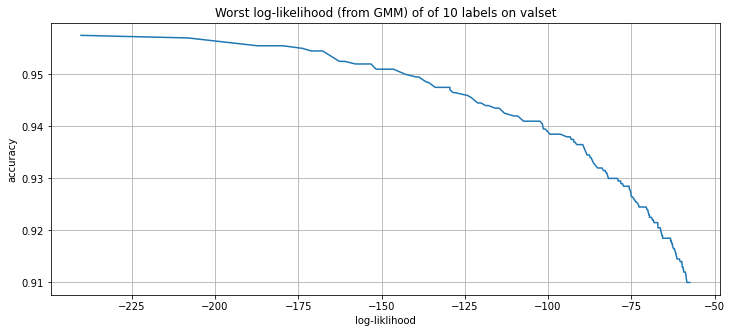

In [ ]:
n_max = 300

n_worst = np.arange(n_max)
risk_list = n_worst/train_size
acc_dict = {"OSR":[],"OSR OOD": [],"OSR OOD only":[] }
sorted_scores = np.sort(osr_model.scores)[:n_max ]

val_acc_list = []
for risk in risk_list:
    ood_pred_valy, ood_val_pred=osr_model.forward(valz,pred_valy,risk=risk)
    val_acc = np.sum(np.array((ood_pred_valy==valy)).astype(int))/len(valy)
    val_acc_list.append(val_acc)        
    
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
ax.plot(sorted_scores,val_acc_list)
ax.set_title('Worst log-likelihood (from GMM) of of 10 labels on valset')
ax.set_xlabel('log-liklihood')
ax.set_ylabel('accuracy')
plt.grid()
plt.show()

### Inference: Pick the threshold 

After observing the curve, we can easily see that the slope after -175 becomes larger, so raising the threshold after -190 can result in sub-optimal results, and lower overall accuracy. 

In [ ]:
best_threshold = -175
osr_model.threshold = best_threshold 
best_risk = sum(i <= best_threshold for i in sorted_scores)/train_size
print("log-likelihood threshold: " + str(best_threshold))
print("best risk: " + str(best_risk))

log-likelihood threshold: -175
best risk: 0.0004


##### Plot the threshold

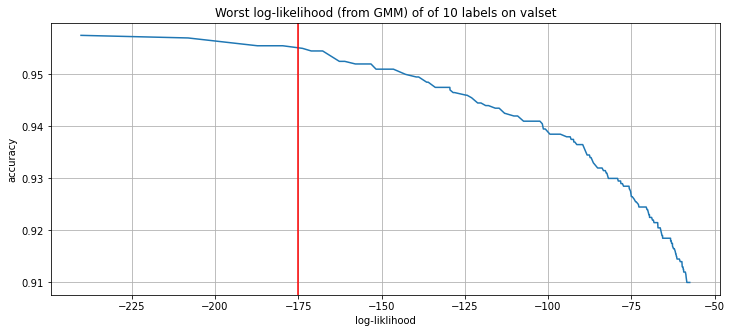

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
ax.plot(sorted_scores,val_acc_list)
ax.set_title('Worst log-likelihood (from GMM) of of 10 labels on valset')
ax.set_xlabel('log-liklihood')
ax.set_ylabel('accuracy')
plt.axvline(x = best_threshold, color = 'r', label = 'axvline - full height')
plt.grid()
plt.show()

Run GMM on the trainset latent representation with 10 gaussians and get the log-likelihood for the validation set.
The given log-likelihood value will be used to determine which examples are OOD in the OSR test.



#### Get the log-likelihood of the OSR-testset, the predicted OOD examples will be labeled as 10.

In [ ]:
# the prediction with 11 labels and with binary labels
ood_pred_y, ood_pred = osr_model.forward(z = testz,
                                        pred_y = pred_testy,
                                        risk = best_risk)
# extract the true binary labels
ood_true = np.array(testy==10, dtype=int)

# 4) Evaluation


### OOD results - Confusion Matrix

True size (OOD size) = 500
False size (in-distribution size) = 10000


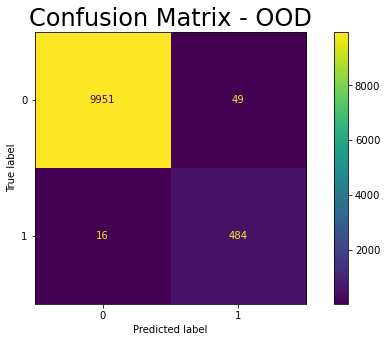

In [ ]:
labels = [0,1]
cm = confusion_matrix(ood_true, ood_pred , labels=labels)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
ax.set_title("Confusion Matrix - OOD", fontsize= 24)

cmp.plot(ax=ax)

print("True size (OOD size) = " + str(ood_size ))
print("False size (in-distribution size) = " + str(test_size ))

### Inference:
The table above shows how well our OSR model performed in classifying the OOD examples. We would like to pay special attention to the right size of the table. We can see that a large fraction of the OOD example have been correctly classfied, but it came with a price of "sacrificing" a small portion of the in distributuion examples and labeling them as OOD. These numbers are influenced by the $risk$ param mentioned earlier.

If we had to lower the threshold we would expect to see a higher TP (true label and predicted label =1), but the tradeoff is that it will incease the FP. returning large number of in distribtuion examples as unknown. 

### ODD results - t-SNE representation

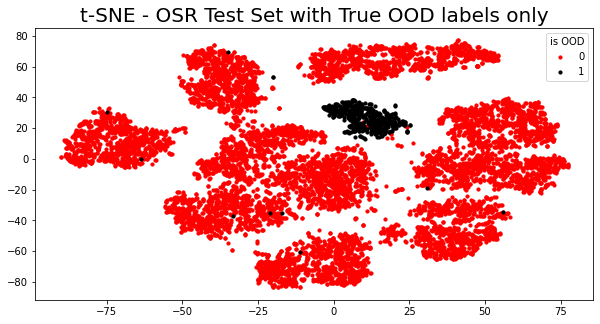

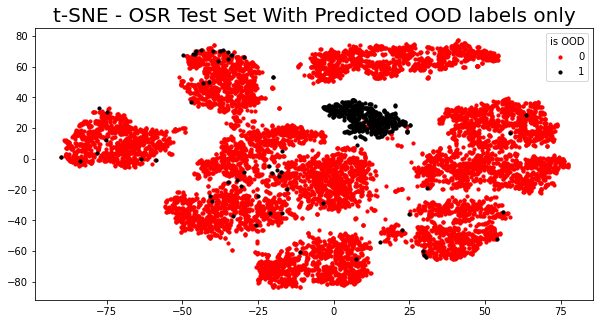

In [ ]:

tsne = TSNE(2,learning_rate='auto')
testz_2D = tsne.fit_transform(X = testz)

colors = [ "r","black"] 
color_keys = np.array([0,1])
  
plt.figure(figsize=(10,5))
for i in color_keys:
    indx = np.where(np.array(ood_true)==i)[0]
    plt.scatter(testz_2D[indx ,0],
                testz_2D[indx ,1],
                s = 10,
                color = colors[i])
    
plt.title("t-SNE - OSR Test Set with True OOD labels only",size = 20)
plt.legend(color_keys.astype(str), title = 'is OOD',loc ="upper right")
plt.show() 


colors = [ "r","black"] 
color_keys = np.array([0,1])
  
plt.figure(figsize=(10,5))
for i in color_keys:
    indx = np.where(np.array(ood_pred)==i)[0]
    plt.scatter(testz_2D[indx ,0],
                testz_2D[indx ,1],
                s = 10,
                color = colors[i])
    
plt.title("t-SNE - OSR Test Set With Predicted OOD labels only",size = 20)
plt.legend(color_keys.astype(str), title = 'is OOD',loc ="upper right")
plt.show() 

## OSR results
### OSR results - Confusion Matrix

0 label size: 980
1 label size: 1135
2 label size: 1032
3 label size: 1010
4 label size: 982
5 label size: 892
6 label size: 958
7 label size: 1028
8 label size: 974
9 label size: 1009
10 label size: 500
All: 10500


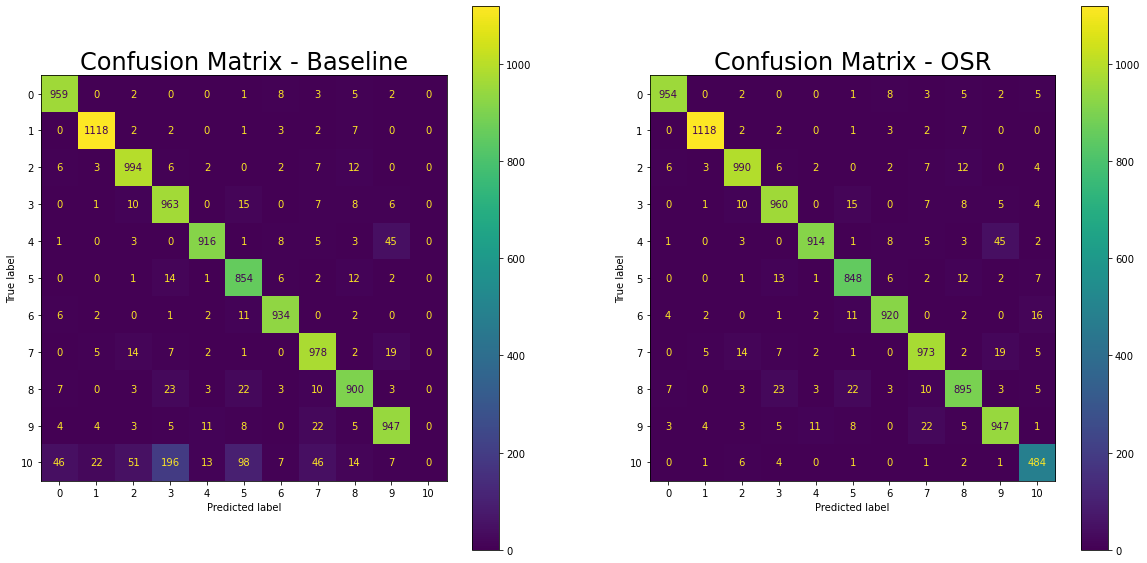

In [ ]:
labels = np.arange(0,11)
cm = confusion_matrix(testy, pred_testy, labels=labels)
cm_OOD = confusion_matrix(testy, ood_pred_y, labels=labels)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
cmp_OOD = ConfusionMatrixDisplay(confusion_matrix=cm_OOD,display_labels=labels)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax[0].set_title("Confusion Matrix - Baseline", fontsize= 24)
ax[1].set_title("Confusion Matrix - OSR", fontsize= 24)
cmp.plot(ax=ax[0])
cmp_OOD.plot(ax=ax[1])

for l in labels:
    print(str(l)+" label size: " +str(np.count_nonzero(testy == l)))
print("All: " + str(len(testy)))

### Inferece: 
Here we can see a confusion matrix with all 11 labels for the baseline model and the osr model. We can clearly see that the baseline model oubviously does not predict any unkown label, because the OSR model is taksed to do so. We can conclude a significant improvement in accuracy in the unknown dataset when the OSR model is applied.

### OSR results - t-SNE

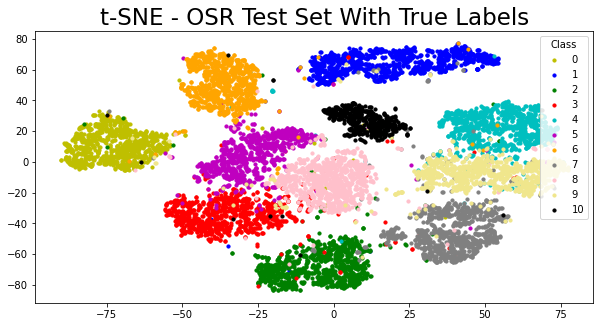

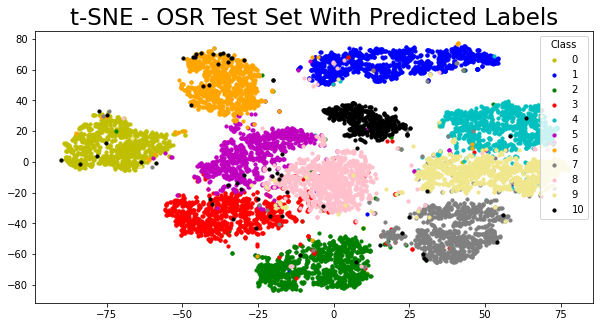

In [ ]:


colors = [ "y", "b","g","r","c","m","orange", "grey", "pink","khaki","black"] 
color_keys = np.arange(0,11)
  
plt.figure(figsize=(10,5))
for i in color_keys:
    indx = np.where(np.array(testy)==i)[0]
    plt.scatter(testz_2D[indx ,0],
                testz_2D[indx ,1],
                s = 10,
                color = colors[i])
    
plt.title("t-SNE - OSR Test Set With True Labels",size = 23)
plt.legend(color_keys.astype(str), title = 'Class',loc ="upper right")
plt.show() 

colors = [ "y", "b","g","r","c","m","orange", "grey", "pink","khaki","black"] 
color_keys = np.arange(0,11)
  
plt.figure(figsize=(10,5))
for i in color_keys:
    indx = np.where(np.array(ood_pred_y)==i)[0]
    plt.scatter(testz_2D[indx ,0],
                testz_2D[indx ,1],
                s = 10,
                color = colors[i])
    
plt.title("t-SNE - OSR Test Set With Predicted Labels",size = 23)
plt.legend(color_keys.astype(str), title = 'Class',loc ="upper right")
plt.show() 

### Accuracy Comparison

Here we show the result of the accuracy metric on the Baseline and OSR w.r.t. the OOD data.

In [ ]:
def create_acc_comp():
    
    baseline_acc = accuracy_score(testy, pred_testy)
    osr_acc = accuracy_score(testy, ood_pred_y)
    ood_cm = confusion_matrix(ood_true, ood_pred)

    baseline_acc_ood = 0
    osr_acc_ood = accuracy_score(ood_true, ood_pred)
    osr_prec_ood = precision_score(ood_true, ood_pred)
    osr_sen_ood = ood_cm[1,1]/ood_size
    index_ood = np.where(testy == 10)[0]
    
    osr_ood_only_acc = accuracy_score(np.ones((ood_size)), ood_pred[index_ood])
    osr_ood_only_prec = precision_score(np.ones((ood_size)), ood_pred[index_ood])
    osr_ood_only_sen =  ood_cm[1,1]/ood_size
    
    accuracy_list = [baseline_acc, osr_acc, baseline_acc_ood, osr_acc_ood ,0,osr_ood_only_acc] 
    precision_list = [None, None, 0, osr_prec_ood ,0,osr_ood_only_prec] 
    sensitivity_list = [None, None, 0, osr_sen_ood ,0,osr_ood_only_sen] 

    description = ["Classification of 10 labels + unknowns (baseline)",
                  "Classification of 10 labels + unknowns (OSR)",
                  "all examples - Baseline (binary labels)",
                  "all examples - OSR (binary labels)",
                  "OOD examples only - Baseline (binary labels)",
                  "OOD examples only (binary labels)"]

    metrics = pd.DataFrame(columns = ['Accuracy','Precision','Sensitivity','Description' ],
                          index = ['Baseline','OSR','Baseline OOD',
                                   'OSR OOD','Baseline OOD only',"OSR OOD only"] )
    metrics['Accuracy'] = accuracy_list
    metrics['Precision'] = precision_list
    metrics['Sensitivity'] = sensitivity_list
    metrics['Description'] = description

    return  metrics
create_acc_comp()

,Accuracy,Precision,Sensitivity,Description
Baseline,0.910762,NaN,NaN,Classification of 10 labels + unknowns (baseline)
OSR,0.952667,NaN,NaN,Classification of 10 labels + unknowns (OSR)
Baseline OOD,0.000000,0.000000,0.000,all examples - Baseline (binary labels)
OSR OOD,0.993810,0.908068,0.968,all examples - OSR (binary labels)
Baseline OOD only,0.000000,0.000000,0.000,OOD examples only - Baseline (binary labels)
OSR OOD only,0.968000,1.000000,0.968,OOD examples only (binary labels)


### Inference:
##### Baseline and OSR:
 
The OSR models shows an impressive improvement in the overall accuracy, due to correcly classying the majority of the unkown label.

##### Baseline OOD:

The accuracy and precision are 0 because the baseline models is not tasked with distinguishing between OOD and not OOD.

##### OSR OOD:

The important metric here is Precision which is the (true positive)/(true positive + false positive). As we saw our final true positive is very high, which is a good thing, but at what expense? our task was also to avoid false positive results in addition to true positive. In other words minimize the number of in-distrubtions examples being classified as OOD. Therefore it is important not only achieving high accuracy but also high precision.

Another important metric is sensitivy, which shows the true positive rate. the precentage of TP out of the 500 OOD examples. As we can see it is  ~0.97


##### Baseline OOD only:

The accuracy, precision and sensitivity are 0 because the baseline models is not tasked with distinguishing between OOD and not OOD.

##### OSR OOD only:

The final accuracy of the 500 OOD examples is ~97%, which is also the sensitivity. 



### The Impact of -risk- (log-likelihood threshold)  on the test set (inference only)

In this next cell we compute some stats for some inference for the next cells.

In [ ]:

n_worst = np.arange(n_max)
risk_list = n_worst/train_size
risk_list = np.linspace(0.99,0,n_max)
acc_dict = {"OSR":[],"OSR OOD": [],"OSR OOD only":[] }
ood_true = np.array(testy==10, dtype=int)

sen_ood  = []
spec_ood = []

# get the specifity and sensitivity of each risk parameter for the ROC curve.
for risk in risk_list:
    ood_pred_y, ood_pred=osr_model.forward(testz,pred_testy,risk=risk)
    ood_cm = confusion_matrix(ood_true, ood_pred)
    cm = confusion_matrix(testy, ood_pred_y) 

    # FN,TP,TN and FP for the OOD data
    FN_ood = ood_cm[1,0]
    TP_ood = ood_cm[1,1]
    TN_ood = ood_cm[0,0]
    FP_ood = ood_cm[0,1]
    sensitivity_ood = TP_ood/(TP_ood + FN_ood) 
    specificity_ood = TN_ood/(TN_ood + FP_ood)

    sen_ood.append(sensitivity_ood)
    spec_ood.append(specificity_ood)

# get the results for the chosen threshold for comparison
ood_pred_y, ood_pred=osr_model.forward(testz,pred_testy,risk=best_risk)
ood_cm = confusion_matrix(ood_true, ood_pred)
cm = confusion_matrix(testy, ood_pred_y) 

FN_ood = ood_cm[1,0]
TP_ood = ood_cm[1,1]
TN_ood = ood_cm[0,0]
FP_ood = ood_cm[0,1]
sensitivity_ood = TP_ood/(TP_ood + FN_ood) 
specificity_ood = TN_ood/(TN_ood + FP_ood)
best_spec = specificity_ood

### ROC curve

The red line is where our threshold is located.

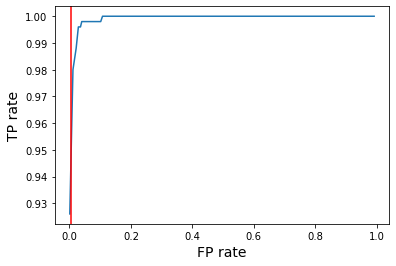

In [ ]:
inds =  (1 - np.array(spec_ood)).argsort()
y_ = np.array(sen_ood)[inds]
x_ = np.sort((1 - np.array(spec_ood)))
plt.plot(x_, y_)
x = np.linspace(0,1,len(x_))
plt.axvline(x = 1-best_spec, color = 'red', label = 'axvline - full height')
plt.ylabel('TP rate', fontsize=14)
plt.xlabel('FP rate', fontsize=14)

plt.show()


### Inference: 

The plot above describes the relationship between the FP rate and the TP rate (ROC curve). we can try to depict what would have happend with a different threshold, our threshold is marked with the red vertical line. It shows that our threshold achieves very low false positive examples and high true positive with a good relationship.

In [ ]:

n_worst = np.arange(n_max)
risk_list = n_worst/train_size
acc_dict = {"OSR":[],"OSR OOD": [],"OSR OOD only":[], "OSR OOD TP" :[]}
ood_true = np.array(testy==10, dtype=int)

sen  = np.array([])
roc = np.array([])
for risk in risk_list:
    
    ood_pred_y, ood_pred=osr_model.forward(testz,pred_testy,risk=risk)
    # All label prediction with unknowns (11 labels)
    metrics = create_acc_comp()
    acc_dict["OSR"].append(metrics.iloc[1][0])
    acc_dict["OSR OOD"].append(metrics.iloc[3][0])
    acc_dict["OSR OOD only"].append(metrics.iloc[3][1])
    acc_dict["OSR OOD TP" ].append(metrics.iloc[3][2])


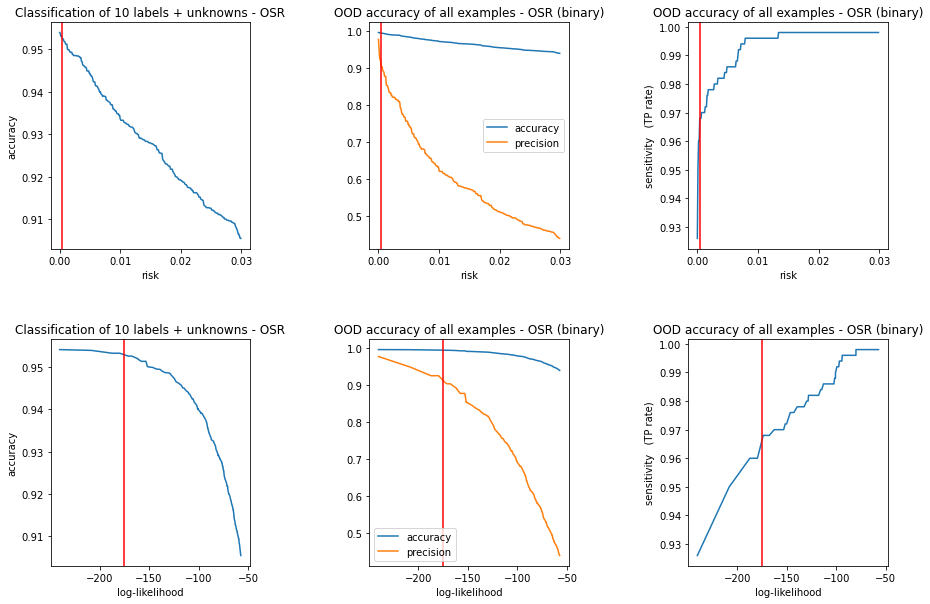

In [ ]:

fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (15,10))

ax[0,0].plot(risk_list,acc_dict['OSR'])
ax[0,0].set_title('Classification of 10 labels + unknowns - OSR')
ax[0,0].set_xlabel('risk')
ax[0,0].set_ylabel('accuracy')
ax[0,0].axvline(x = best_risk, color = 'red', label = 'axvline - full height')

ax[0,1].plot(risk_list, acc_dict['OSR OOD'])
ax[0,1].plot(risk_list, acc_dict['OSR OOD only'])
ax[0,1].set_title('OOD accuracy of all examples - OSR (binary)')
ax[0,1].set_xlabel('risk')
ax[0,1].legend(['accuracy','precision'])
ax[0,1].axvline(x = best_risk, color = 'red', label = 'axvline - full height')

ax[0,2].plot(risk_list, acc_dict["OSR OOD TP"])
ax[0,2].set_title('OOD accuracy of all examples - OSR (binary)')
ax[0,2].set_xlabel('risk')
ax[0,2].set_ylabel('sensitivity   (TP rate)')
ax[0,2].axvline(x = best_risk, color = 'red', label = 'axvline - full height')


ax[1,0].plot(np.sort(osr_model.scores)[:n_max ],acc_dict['OSR'])
ax[1,0].set_title('Classification of 10 labels + unknowns - OSR')
ax[1,0].set_xlabel('log-likelihood')
ax[1,0].set_ylabel('accuracy')
ax[1,0].axvline(x = best_threshold, color = 'red', label = 'axvline - full height')

ax[1,1].plot(np.sort(osr_model.scores)[:n_max ], acc_dict['OSR OOD'])
ax[1,1].plot(np.sort(osr_model.scores)[:n_max ], acc_dict['OSR OOD only'])
ax[1,1].set_title('OOD accuracy of all examples - OSR (binary)')
ax[1,1].set_xlabel('log-likelihood')
ax[1,1].legend(['accuracy','precision'])
ax[1,1].axvline(x = best_threshold, color = 'red', label = 'axvline - full height')

ax[1,2].plot(np.sort(osr_model.scores)[:n_max ],acc_dict["OSR OOD TP"])
ax[1,2].set_title('OOD accuracy of all examples - OSR (binary)')
ax[1,2].set_xlabel('log-likelihood')
ax[1,2].set_ylabel('sensitivity   (TP rate)')
ax[1,2].axvline(x = best_threshold, color = 'red', label = 'axvline - full height')



plt.subplots_adjust( wspace=0.6)
plt.subplots_adjust( hspace=0.4)
plt.show()

### Inference: How will our method perform on other datsets
Here we see the relationship of he train log-likelihood threshold and risk values. Similar to earlier plots, the red vertical line marks the chosen threshold.\
These plots show what would have been the accuracy and precision given different thresholds, in other words it puts our method to a test.\
The results show that with a less tighter threshold we could have potentialy gotten better results for the overall accuracy and precision, whereas the sensitivity decreseas drastically, meaning out of the 500 OOD example, a larger amount would be classified in distribtuion. This brings us to the reason why we risk a portion of the train examples for generalization. Additionaly, with the application on a different OOD test set the benifit could be more visible, and the generalization could pay more off.


But this is only an example of the CIFAR10 dataset as OOD. Since our approach is designed to be more generalized we expect to get also competative results on datasets with not only pictures of objects but also pictures of number and letter OOD.

### Other Trials

As part of our process of finding a method for solve the presented problem we tried different methods, most of wich were unsuccessful.
Some of the clustering algorithms we conducted trials with:

* DBSCAN
* PCA
* Denclue
* k-means

more descriptive information about the process and the decision making is presented in the attached pdf.

# References

 [1]  <a name="[1]"></a> RandAugment: Practical automated data augmentation with a reduced search space
 
 [2]  <a name="[2]"></a> Domain Generalization for Object Recognition with Multi-task Autoencoders
 
 [3] <a name="[3]"></a> DENCLUE 2.0: Fast Clustering based on Kernel Density Estimation

